# Imports
## Run these

In [1]:
# RUN

import copy
import argparse

import os
os.environ["OPENCV_VIDEOIO_MSMF_ENABLE_HW_TRANSFORMS"] = "0"

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# For FPS
from collections import deque

In [2]:
### MODIFYING Mediapipe Holistics for capturing Shoulder + Arms + Hands only
from mediapipe.python.solutions.drawing_utils import DrawingSpec
from mediapipe.python.solutions.holistic import PoseLandmark

In [3]:
# list of landmarks to include on the image
included_landmarks = [
    # right hand set
    PoseLandmark.RIGHT_SHOULDER,
    PoseLandmark.RIGHT_ELBOW,
    PoseLandmark.RIGHT_WRIST,

    # left hand set
    PoseLandmark.LEFT_SHOULDER,
    PoseLandmark.LEFT_ELBOW,
    PoseLandmark.LEFT_WRIST,
    # thumb, index and pinky are not required, since they are included in hand landmarks
]

In [4]:
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
# Mostly for FPS calc

class CvFpsCalc(object):
    def __init__(self, buffer_len=1):
        self._start_tick = cv.getTickCount()
        self._freq = 1000.0 / cv.getTickFrequency()
        self._difftimes = deque(maxlen=buffer_len)

    def get(self):
        current_tick = cv.getTickCount()
        different_time = (current_tick - self._start_tick) * self._freq
        self._start_tick = current_tick

        self._difftimes.append(different_time)

        fps = 1000.0 / (sum(self._difftimes) / len(self._difftimes))
        fps_rounded = round(fps, 2)

        return fps_rounded

# Misc funcs

### Hand Landmarks Visualization

In [6]:
def draw_hand_v2(image, hand_landmarks):
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_point = []

    if hand_landmarks:
        for index, landmark in enumerate(hand_landmarks.landmark):
            if landmark.visibility < 0 or landmark.presence < 0:
                continue
    
            landmark_x = min(int(landmark.x * image_width), image_width - 1)
            landmark_y = min(int(landmark.y * image_height), image_height - 1)
            landmark_z = landmark.z
    
            landmark_point.append((landmark_x, landmark_y))
    
            if index == 0:  # 手首1
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 1:  # 手首2
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 2:  # 親指：付け根
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 3:  # 親指：第1関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 4:  # 親指：指先
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
            if index == 5:  # 人差指：付け根
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 6:  # 人差指：第2関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 7:  # 人差指：第1関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 8:  # 人差指：指先
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
            if index == 9:  # 中指：付け根
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 10:  # 中指：第2関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 11:  # 中指：第1関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 12:  # 中指：指先
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
            if index == 13:  # 薬指：付け根
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 14:  # 薬指：第2関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 15:  # 薬指：第1関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 16:  # 薬指：指先
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
            if index == 17:  # 小指：付け根
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 18:  # 小指：第2関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 19:  # 小指：第1関節
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            if index == 20:  # 小指：指先
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
    
            # if not upper_body_only:
            if True:
                cv.putText(image, "z:" + str(round(landmark_z, 3)),
                           (landmark_x - 10, landmark_y - 10),
                           cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                           cv.LINE_AA)
    
        # 接続線
        if len(landmark_point) > 0:
            # 親指
            cv.line(image, landmark_point[2], landmark_point[3], (0, 255, 0), 2)
            cv.line(image, landmark_point[3], landmark_point[4], (0, 255, 0), 2)
    
            # 人差指
            cv.line(image, landmark_point[5], landmark_point[6], (0, 255, 0), 2)
            cv.line(image, landmark_point[6], landmark_point[7], (0, 255, 0), 2)
            cv.line(image, landmark_point[7], landmark_point[8], (0, 255, 0), 2)
    
            # 中指
            cv.line(image, landmark_point[9], landmark_point[10], (0, 255, 0), 2)
            cv.line(image, landmark_point[10], landmark_point[11], (0, 255, 0), 2)
            cv.line(image, landmark_point[11], landmark_point[12], (0, 255, 0), 2)
    
            # 薬指
            cv.line(image, landmark_point[13], landmark_point[14], (0, 255, 0), 2)
            cv.line(image, landmark_point[14], landmark_point[15], (0, 255, 0), 2)
            cv.line(image, landmark_point[15], landmark_point[16], (0, 255, 0), 2)
    
            # 小指
            cv.line(image, landmark_point[17], landmark_point[18], (0, 255, 0), 2)
            cv.line(image, landmark_point[18], landmark_point[19], (0, 255, 0), 2)
            cv.line(image, landmark_point[19], landmark_point[20], (0, 255, 0), 2)
    
            # 手の平
            cv.line(image, landmark_point[0], landmark_point[1], (0, 255, 0), 2)
            cv.line(image, landmark_point[1], landmark_point[2], (0, 255, 0), 2)
            cv.line(image, landmark_point[2], landmark_point[5], (0, 255, 0), 2)
            cv.line(image, landmark_point[5], landmark_point[9], (0, 255, 0), 2)
            cv.line(image, landmark_point[9], landmark_point[13], (0, 255, 0), 2)
            cv.line(image, landmark_point[13], landmark_point[17], (0, 255, 0), 2)
            cv.line(image, landmark_point[17], landmark_point[0], (0, 255, 0), 2)

    return image

### Shoulders + Arms

In [7]:
def draw_pose_landmarks_v2(
    image,
    landmarks,
    # upper_body_only,
    visibility_th=0.5,
):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    if landmarks:
        for index, landmark in enumerate(landmarks.landmark):
            landmark_x = min(int(landmark.x * image_width), image_width - 1)
            landmark_y = min(int(landmark.y * image_height), image_height - 1)
            landmark_z = landmark.z
            landmark_point.append([landmark.visibility, (landmark_x, landmark_y)])
    
            if landmark.visibility < visibility_th:
                continue
    
            if index in included_landmarks:
                cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
                cv.putText(image, "z:" + str(round(landmark_z, 3)),
                           (landmark_x - 10, landmark_y - 10),
                           cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                           cv.LINE_AA)
    
        if len(landmark_point) > 0:
            # 肩 - Shoulders
            if landmark_point[11][0] > visibility_th and landmark_point[12][
                    0] > visibility_th:
                cv.line(image, landmark_point[11][1], landmark_point[12][1],
                        (0, 255, 0), 2)
    
            # 右腕 - Right Arm
            if landmark_point[11][0] > visibility_th and landmark_point[13][
                    0] > visibility_th:
                cv.line(image, landmark_point[11][1], landmark_point[13][1],
                        (0, 255, 0), 2)
            if landmark_point[13][0] > visibility_th and landmark_point[15][
                    0] > visibility_th:
                cv.line(image, landmark_point[13][1], landmark_point[15][1],
                        (0, 255, 0), 2)
    
            # 左腕 - Left Arm
            if landmark_point[12][0] > visibility_th and landmark_point[14][
                    0] > visibility_th:
                cv.line(image, landmark_point[12][1], landmark_point[14][1],
                        (0, 255, 0), 2)
            if landmark_point[14][0] > visibility_th and landmark_point[16][
                    0] > visibility_th:
                cv.line(image, landmark_point[14][1], landmark_point[16][1],
                        (0, 255, 0), 2)

        
    return image

### Rect Drawing

In [8]:
def calc_bounding_rect(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0, 2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point = [np.array((landmark_x, landmark_y))]

        landmark_array = np.append(landmark_array, landmark_point, axis=0)

    x, y, w, h = cv.boundingRect(landmark_array)

    return [x, y, x + w, y + h]

In [9]:
def draw_bounding_rect(use_brect, image, brect):
    if use_brect:
        # 外接矩形
        cv.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]),
                     (0, 255, 0), 2)

    return image

### Prolly unused for the most part

In [10]:
def mediapipe_detection(image, model):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is not writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is again writeable 
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR) 
    return image, results

In [11]:
#defining landmarks for each body component
def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

-----

In [10]:
# def get_args():
#     parser = argparse.ArgumentParser()

#     parser.add_argument("--device", type=int, default=0)
#     parser.add_argument("--width", help='cap width', type=int, default=960) # 720
#     parser.add_argument("--height", help='cap height', type=int, default=720) # 540

#     parser.add_argument('--unuse_smooth_landmarks', action='store_true')
#     parser.add_argument("--model_complexity",
#                         help='model_complexity(0,1(default),2)',
#                         type=int,
#                         default=1)
#     parser.add_argument("--min_detection_confidence",
#                         help='face mesh min_detection_confidence',
#                         type=float,
#                         default=0.5)
#     parser.add_argument("--min_tracking_confidence",
#                         help='face mesh min_tracking_confidence',
#                         type=int,
#                         default=0.5)


#     parser.add_argument('--use_brect', action='store_true',
#                         default=True)


#     args = parser.parse_args()

#     return args

### Not necessarily needed since we already have them in later code blocks

In [12]:
# LIVE FEED
# args = get_args()

cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = True

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

### OLD VER
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():
#         ret, frame = cap.read()
#         image, results = mediapipe_detection(frame, holistic)
        
#         # Draw landmarks
#         draw_landmarks(image, results)
        
#         cv2.imshow('LIVE CAM FEED', image)

#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             print('Live Feed Terminated')
#             break
#     cap.release()
#     cv2.destroyAllWindows()

True

In [13]:
# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

In [14]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

In [15]:
while True:
    display_fps = cvFpsCalc.get()

    # Camera Capture #####################################################
    ret, image = cap.read()
    if not ret:
        break
    image = cv.flip(image, 1)  # ミラー表示
    debug_image = copy.deepcopy(image)

    # Holistics Processing #############################################################
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True

    pose_landmarks = results.pose_landmarks
    if pose_landmarks is not None:
        # 外接矩形の計算
        brect = calc_bounding_rect(debug_image, pose_landmarks)
        # 描画
        debug_image = draw_pose_landmarks_v2(
            debug_image,
            pose_landmarks
        )
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # Hands ###############################################################
    left_hand_landmarks = results.left_hand_landmarks
    right_hand_landmarks = results.right_hand_landmarks
    # 左手
    if left_hand_landmarks is not None:
        brect = calc_bounding_rect(debug_image, left_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)
    # 右手
    if right_hand_landmarks is not None:
        
        brect = calc_bounding_rect(debug_image, right_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # FPS表示
    fps_color = (0, 255, 0)
    cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
               cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)

    # キー処理(ESC：終了) #################################################
    key = cv.waitKey(1)
    if key == 27:  # ESC
        break

    # 画面反映 #############################################################
    cv.imshow('MediaPipe Holistic Demo', debug_image)

cap.release()
cv.destroyAllWindows()

### Landmark Drawing Test on Image

In [43]:
test_image = cv.imread("K:/Pycharm/NLN/_holistics/__DATASET/5. StaticLTilt/IMG_30/2/0.png")

In [44]:
results = holistic.process(test_image)

In [45]:
results.right_hand_landmarks.landmark

[x: 0.4257776
y: 0.7552708
z: -3.1431813e-07
, x: 0.41264153
y: 0.7192955
z: -0.013966188
, x: 0.4172585
y: 0.6929697
z: -0.028292326
, x: 0.43362913
y: 0.6911933
z: -0.038723357
, x: 0.44881386
y: 0.7149047
z: -0.04765974
, x: 0.40098676
y: 0.7399867
z: -0.055019606
, x: 0.4249439
y: 0.71906847
z: -0.07035889
, x: 0.41385296
y: 0.71992666
z: -0.07092003
, x: 0.4036083
y: 0.729801
z: -0.06913495
, x: 0.41159487
y: 0.7719337
z: -0.05279157
, x: 0.43999746
y: 0.7366096
z: -0.06876683
, x: 0.42952797
y: 0.7368688
z: -0.061856702
, x: 0.41992286
y: 0.74991727
z: -0.056105975
, x: 0.42748213
y: 0.7922594
z: -0.04909324
, x: 0.45271397
y: 0.7545211
z: -0.062289733
, x: 0.4401793
y: 0.75361156
z: -0.04958782
, x: 0.4293189
y: 0.76471436
z: -0.039231077
, x: 0.44249764
y: 0.80352926
z: -0.04596368
, x: 0.45922115
y: 0.77212006
z: -0.052303918
, x: 0.45005268
y: 0.76922584
z: -0.043923788
, x: 0.44028288
y: 0.77973974
z: -0.037683193
]

In [46]:
results.left_hand_landmarks.landmark

[x: 0.591151
y: 0.56637216
z: -9.3300685e-08
, x: 0.5827259
y: 0.5398356
z: -0.004568518
, x: 0.5714785
y: 0.5160758
z: -0.011345677
, x: 0.5645951
y: 0.4920074
z: -0.01825522
, x: 0.56243575
y: 0.47748482
z: -0.025391018
, x: 0.56266266
y: 0.5380521
z: -0.016740669
, x: 0.5443682
y: 0.5529986
z: -0.025392076
, x: 0.55659825
y: 0.5528982
z: -0.02970788
, x: 0.5689799
y: 0.5458621
z: -0.032466147
, x: 0.56964844
y: 0.56335074
z: -0.018969184
, x: 0.5524919
y: 0.5733717
z: -0.02476112
, x: 0.5671917
y: 0.571079
z: -0.023436103
, x: 0.57582366
y: 0.5661945
z: -0.02424269
, x: 0.57794213
y: 0.5863108
z: -0.021345885
, x: 0.56417656
y: 0.5937455
z: -0.025818633
, x: 0.575989
y: 0.5904235
z: -0.018452875
, x: 0.5850092
y: 0.58561033
z: -0.014880875
, x: 0.5877382
y: 0.6034197
z: -0.024233954
, x: 0.5765789
y: 0.6104011
z: -0.024860641
, x: 0.58513594
y: 0.6060476
z: -0.017169965
, x: 0.5923215
y: 0.6020545
z: -0.012978266
]

In [47]:
results.left_hand_landmarks.landmark[9]

x: 0.56964844
y: 0.56335074
z: -0.018969184

In [48]:
results.left_hand_landmarks.landmark[9].x

0.5696484446525574

In [49]:
results.left_hand_landmarks.landmark[9].y

0.5633507370948792

In [19]:
results.right_hand_landmarks

landmark {
  x: 0.3577247
  y: 0.64847887
  z: -2.9896505e-08
}
landmark {
  x: 0.3688213
  y: 0.6086613
  z: -0.009735799
}
landmark {
  x: 0.39763522
  y: 0.58137906
  z: -0.02195209
}
landmark {
  x: 0.4268658
  y: 0.5777853
  z: -0.030572023
}
landmark {
  x: 0.44302088
  y: 0.59518474
  z: -0.03744303
}
landmark {
  x: 0.38107038
  y: 0.60230213
  z: -0.04972523
}
landmark {
  x: 0.43070385
  y: 0.59685737
  z: -0.064417996
}
landmark {
  x: 0.42749205
  y: 0.5897745
  z: -0.064395495
}
landmark {
  x: 0.41420433
  y: 0.5881831
  z: -0.06105452
}
landmark {
  x: 0.3824828
  y: 0.6337154
  z: -0.04928935
}
landmark {
  x: 0.43778065
  y: 0.6232101
  z: -0.06302877
}
landmark {
  x: 0.4309001
  y: 0.61495256
  z: -0.05652661
}
landmark {
  x: 0.41537958
  y: 0.6180522
  z: -0.049865376
}
landmark {
  x: 0.38725752
  y: 0.66086465
  z: -0.047360733
}
landmark {
  x: 0.43875486
  y: 0.64969915
  z: -0.054018646
}
landmark {
  x: 0.43222368
  y: 0.63769925
  z: -0.043177616
}
landmark 

In [45]:
test_image = draw_pose_landmarks_v2(test_image, results.pose_landmarks)
test_image = draw_hand_v2(test_image, results.left_hand_landmarks)
test_image = draw_hand_v2(test_image, results.right_hand_landmarks)

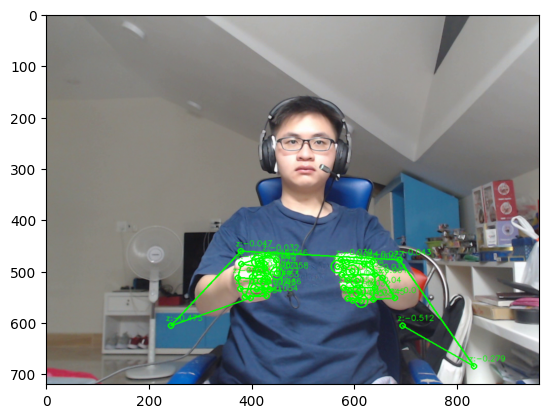

In [46]:
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

In [272]:
# draw_landmarks(frame, results)

In [270]:
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Reading Multiple Images Sandbox

### One of the problems we'd have to face here is that our hands can be motion blurred

In [46]:
# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=1,
    smooth_landmarks=False,
    enable_segmentation=False,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
)

In [40]:
test_image_2 = cv.imread("F:/OBS REcs/Thesus Data/5FPS Test 2/img2/0/2.png")

In [41]:
results2 = holistic.process(test_image_2)

In [42]:
results2.left_hand_landmarks

In [43]:
test_image_2 = draw_pose_landmarks_v2(test_image_2, results2.pose_landmarks)
test_image_2 = draw_hand_v2(test_image_2, results2.left_hand_landmarks)
test_image_2 = draw_hand_v2(test_image_2, results2.right_hand_landmarks)

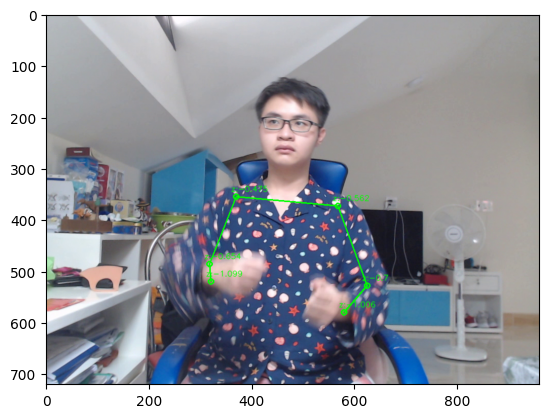

In [44]:
plt.imshow(cv.cvtColor(test_image_2, cv.COLOR_BGR2RGB))

In [45]:
extract_keypoints_v2(results2)

array([ 0.59241706,  0.51870239, -0.5621056 ,  0.99875951,  0.38625962,
        0.494205  , -0.47457126,  0.99630189,  0.651627  ,  0.73349154,
       -0.6999923 ,  0.96518552,  0.33138493,  0.6762991 , -0.65364701,
        0.82818794,  0.6042735 ,  0.80629474, -1.00557446,  0.83703178,
        0.33535767,  0.72278893, -1.09906423,  0.53632975,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

### As we can all see here, it didn't detect the hands.
And in some cases, the shoulders as well.
We're going to test it with different clothings this time around.

In [47]:
test_image_3 = cv.imread("F:/OBS REcs/Thesus Data/10FPS Test 3/img/0/5.png")

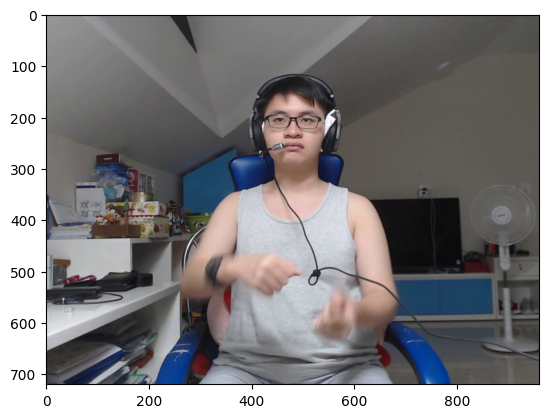

In [48]:
plt.imshow(cv.cvtColor(test_image_3, cv.COLOR_BGR2RGB))

In [49]:
results3 = holistic.process(test_image_3)

In [ ]:
results3.

In [52]:
results3.left_hand_landmarks

In [51]:
results3.right_hand_landmarks

landmark {
  x: 0.38791618
  y: 0.6822295
  z: -1.7957824e-07
}
landmark {
  x: 0.42169565
  y: 0.6623377
  z: -0.0025609862
}
landmark {
  x: 0.46358168
  y: 0.66184664
  z: -0.010326941
}
landmark {
  x: 0.4968579
  y: 0.67550194
  z: -0.017958159
}
landmark {
  x: 0.51859856
  y: 0.69295305
  z: -0.024234079
}
landmark {
  x: 0.4590219
  y: 0.6579564
  z: -0.024019277
}
landmark {
  x: 0.4979608
  y: 0.69322705
  z: -0.036206488
}
landmark {
  x: 0.4876989
  y: 0.6960455
  z: -0.041172642
}
landmark {
  x: 0.47638708
  y: 0.68765974
  z: -0.043833446
}
landmark {
  x: 0.44554752
  y: 0.6785391
  z: -0.029418327
}
landmark {
  x: 0.48456618
  y: 0.71975595
  z: -0.036709677
}
landmark {
  x: 0.47319314
  y: 0.71547055
  z: -0.03355103
}
landmark {
  x: 0.46127307
  y: 0.70447975
  z: -0.033335853
}
landmark {
  x: 0.4343111
  y: 0.70035183
  z: -0.03451834
}
landmark {
  x: 0.47058704
  y: 0.7377547
  z: -0.03694545
}
landmark {
  x: 0.46008912
  y: 0.73015994
  z: -0.027658446
}
lan

In [53]:
test_image_3 = draw_pose_landmarks_v2(test_image_3, results3.pose_landmarks)
test_image_3 = draw_hand_v2(test_image_3, results3.left_hand_landmarks)
test_image_3 = draw_hand_v2(test_image_3, results3.right_hand_landmarks)

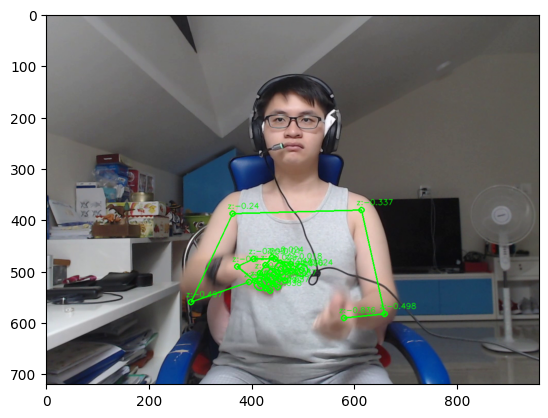

In [54]:
plt.imshow(cv.cvtColor(test_image_3, cv.COLOR_BGR2RGB))

# Extract Keypoint Values

In [48]:
pose = []
for index, landmark in enumerate(results.pose_landmarks.landmark):
    if index in included_landmarks:
        print(index, " - ", landmark, '\n', '---')
        pose.append([landmark.x, landmark.y, landmark.z, landmark.visibility])

11  -  x: 0.7168896
y: 0.6651891
z: -0.043094676
visibility: 0.9990746
 
 ---
12  -  x: 0.39492655
y: 0.64059204
z: -0.047454648
visibility: 0.99888474
 
 ---
13  -  x: 0.8679372
y: 0.95275116
z: -0.27859643
visibility: 0.714029
 
 ---
14  -  x: 0.253861
y: 0.8430307
z: -0.47541708
visibility: 0.75010246
 
 ---
15  -  x: 0.72329986
y: 0.84238535
z: -0.51215243
visibility: 0.82257277
 
 ---
16  -  x: 0.41507605
y: 0.7673333
z: -1.0835589
visibility: 0.8743752
 
 ---


In [49]:
len(pose)

6

In [51]:
pose_flatten = np.copy(pose).flatten()

In [52]:
pose_flatten

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522])

In [53]:
np.zeros(6 * 4)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [55]:
(6*4 + 21*3 + 21*3) * 30

4500

In [56]:
(6*4 + 21*3 + 21*3) * 10

1500

In [57]:
(6*4 + 21*3 + 21*3) * 5

750

In [15]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
#  RUN THIS
def extract_keypoints_v2(results):
    pose = []
    lh = []
    rh = []
    # Pose Landmarks
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x, landmark.y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks
    if results.left_hand_landmarks:
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks
    if results.right_hand_landmarks:
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])
        

In [12]:
np.set_printoptions(suppress=True)

In [61]:
extract_keypoints_v2(results)

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522,  0.70831358,
        0.76679593, -0.00000014,  0.68256032,  0.71336979,  0.00104126,
        0.64562964,  0.67607707, -0.00621779,  0.61082327,  0.66959381,
       -0.01395931,  0.59130645,  0.68219125, -0.02143147,  0.6616956 ,
        0.66996658, -0.02742231,  0.59885287,  0.66526049, -0.03936275,
        0.60435206,  0.68710166, -0.03925093,  0.62118268,  0.69507235,
       -0.03753251,  0.66720665,  0.70526999, -0.03438016,  0.60049641,
        0.70481569, -0.04624613,  0.61192399,  0.72015262, -0.041039  ,
        0.63091248,  0.72093767, -0.03741381,  0.66755819,  0.73935544,
       -0.04005786,  0.60416198,  0.73934424, -0.05041449,  0.61

In [62]:
np.save('0', extract_keypoints_v2(results))

In [14]:
np.load('0.npy')

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522,  0.70831358,
        0.76679593, -0.00000014,  0.68256032,  0.71336979,  0.00104126,
        0.64562964,  0.67607707, -0.00621779,  0.61082327,  0.66959381,
       -0.01395931,  0.59130645,  0.68219125, -0.02143147,  0.6616956 ,
        0.66996658, -0.02742231,  0.59885287,  0.66526049, -0.03936275,
        0.60435206,  0.68710166, -0.03925093,  0.62118268,  0.69507235,
       -0.03753251,  0.66720665,  0.70526999, -0.03438016,  0.60049641,
        0.70481569, -0.04624613,  0.61192399,  0.72015262, -0.041039  ,
        0.63091248,  0.72093767, -0.03741381,  0.66755819,  0.73935544,
       -0.04005786,  0.60416198,  0.73934424, -0.05041449,  0.61

In [ ]:
#UNUSED
# def extract_keypoints(results):
#     pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
#     face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
#     lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
#     rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
#     return np.concatenate([pose, face, lh, rh])

# Coord shifting
We are going to shift our coords to by centered by the LEFT_SHOULDER coord at point (0, 0) - cho điểm LEFT_SHOULDER làm tâm cho các điểm còn lại trên mặt phẳng x, y. <br>
Còn z ta ko cần xử lý

In [56]:
temp_coord_1 = copy.deepcopy(np.load('1.npy'))

In [17]:
temp_coord = copy.deepcopy(np.load('1.npy'))

In [21]:
temp_coord.shape[0]

150

In [18]:
temp_coord

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522,  0.70831358,
        0.76679593, -0.00000014,  0.68256032,  0.71336979,  0.00104126,
        0.64562964,  0.67607707, -0.00621779,  0.61082327,  0.66959381,
       -0.01395931,  0.59130645,  0.68219125, -0.02143147,  0.6616956 ,
        0.66996658, -0.02742231,  0.59885287,  0.66526049, -0.03936275,
        0.60435206,  0.68710166, -0.03925093,  0.62118268,  0.69507235,
       -0.03753251,  0.66720665,  0.70526999, -0.03438016,  0.60049641,
        0.70481569, -0.04624613,  0.61192399,  0.72015262, -0.041039  ,
        0.63091248,  0.72093767, -0.03741381,  0.66755819,  0.73935544,
       -0.04005786,  0.60416198,  0.73934424, -0.05041449,  0.61

In [19]:
# Pose coords
temp_coord[0:24]

# Has x y z vis

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522])

In [53]:
LS_x = temp_coord[0]
LS_y = temp_coord[1]

for i in range(0,24,4):
    print(i)
print("- Pose x -")
for i in temp_coord[0:24:4]:
    if i != 0:
        print(i, " - ", i-LS_x)
    else:
        continue
print("- Pose y -")
for i in temp_coord[1:24:4]:
    if i != 0:
        print(i, " - ", i-LS_y)
    else:
        continue

0
4
8
12
16
20
- Pose x -
0.7168896198272705  -  0.0
0.3949265480041504  -  -0.3219630718231201
0.8679372072219849  -  0.15104758739471436
0.2538610100746155  -  -0.46302860975265503
0.7232998609542847  -  0.00641024112701416
0.41507604718208313  -  -0.3018135726451874
- Pose y -
0.6651890873908997  -  0.0
0.6405920386314392  -  -0.02459704875946045
0.9527511596679688  -  0.2875620722770691
0.8430306911468506  -  0.17784160375595093
0.8423853516578674  -  0.17719626426696777
0.7673333287239075  -  0.10214424133300781


In [33]:
# Hand coords
temp_coord[24:]

# Has x y z

array([ 0.70831358,  0.76679593, -0.00000014,  0.68256032,  0.71336979,
        0.00104126,  0.64562964,  0.67607707, -0.00621779,  0.61082327,
        0.66959381, -0.01395931,  0.59130645,  0.68219125, -0.02143147,
        0.6616956 ,  0.66996658, -0.02742231,  0.59885287,  0.66526049,
       -0.03936275,  0.60435206,  0.68710166, -0.03925093,  0.62118268,
        0.69507235, -0.03753251,  0.66720665,  0.70526999, -0.03438016,
        0.60049641,  0.70481569, -0.04624613,  0.61192399,  0.72015262,
       -0.041039  ,  0.63091248,  0.72093767, -0.03741381,  0.66755819,
        0.73935544, -0.04005786,  0.60416198,  0.73934424, -0.05041449,
        0.6163674 ,  0.74955922, -0.03953978,  0.63525277,  0.74890471,
       -0.03178317,  0.66372257,  0.77151066, -0.04500781,  0.61187887,
        0.76870108, -0.05243115,  0.62198198,  0.77441829, -0.04460132,
        0.63986528,  0.77555358, -0.03813169,  0.4179323 ,  0.71008581,
        0.00000006,  0.43038416,  0.673733  , -0.01546412,  0.44

In [36]:
LS_x = temp_coord[0]
LS_y = temp_coord[1]

# for i in range(24,150,3):
#     print(i)
print("- Hands x -")
for i in temp_coord[24::3]:
    if i != 0:
        print(i, " - ", i-LS_x)
    else:
        continue
print("- Hands y -")
for i in temp_coord[24+1::3]:
    if i != 0:
        print(i, " - ", i-LS_y)
    else:
        continue

- Hands x -
0.7083135843276978  -  -0.008576035499572754
0.6825603246688843  -  -0.03432929515838623
0.6456296443939209  -  -0.07125997543334961
0.6108232736587524  -  -0.10606634616851807
0.5913064479827881  -  -0.12558317184448242
0.6616955995559692  -  -0.05519402027130127
0.5988528728485107  -  -0.11803674697875977
0.6043520569801331  -  -0.11253756284713745
0.6211826801300049  -  -0.09570693969726562
0.6672066450119019  -  -0.04968297481536865
0.6004964113235474  -  -0.11639320850372314
0.6119239926338196  -  -0.10496562719345093
0.6309124827384949  -  -0.08597713708877563
0.6675581932067871  -  -0.0493314266204834
0.6041619777679443  -  -0.11272764205932617
0.6163673996925354  -  -0.10052222013473511
0.6352527737617493  -  -0.08163684606552124
0.663722574710846  -  -0.05316704511642456
0.6118788719177246  -  -0.1050107479095459
0.6219819784164429  -  -0.09490764141082764
0.6398652791976929  -  -0.07702434062957764
0.41793230175971985  -  -0.29895731806755066
0.43038415908813477  

In [ ]:
print(temp_coord)

In [ ]:
for i in range(24,150,3):
    print(i)
temp_coord[149]

In [59]:
    for idx, i in enumerate(temp_coord[0:24:4]):
        if temp_coord[idx] != 0:
            # i = i - LeftSh_x
            print(idx, " - ", i)
        else:
            continue

0  -  0.7168896198272705
1  -  0.3949265480041504
2  -  0.8679372072219849
3  -  0.2538610100746155
4  -  0.7232998609542847
5  -  0.41507604718208313


#### From all of the above, we got this function.
Hooray

This one copies the original array and returns **a modified array**. <br>
Look, I know this is a hassle but better safe than sorry. Modifying array references isn't my thing. <br>
I mean sure if oyu want you can remove the temp_result and change them into result. But that isn't safe at all!

In [13]:
# LeftSh = Left Shoulder - the 11th point in the pose landmark list
# Look, this one is only used to fix most of the dataset that was recorded PRIOR to me
# finding out that I kinda needed to shift the coordinates so that the dataset is somewhat unified.

def shift_coord_arr_fix(result):
    LeftSh_x = result[0]
    LeftSh_y = result[1]
    temp_result = copy.deepcopy(result)

    # Pose
    # print("- Pose x -")
    # for idx, i in enumerate(result[0:24:4]):
    for idx in range(0,24,4):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_x
        else:
            continue
    # print("- Pose y -")
    for idx in range(1,24,4):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_y
        else:
            continue
    # print("- Hands x -")
    for idx in range(24,150,3):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_x
        else:
            continue
    # print("- Hands y -")
    for idx in range(24+1,150,3):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_y
        else:
            continue

    return temp_result

In [14]:
def print_test_shifted(old, result):
    LS_x = old[0]
    LS_y = old[1]
    
    print("- Pose x -")
    for i in range(0,24,4):
        print(old[i], " - ", result[i], " - Checking if match: ", result[i] + LS_x)  # Check if results matches old by adding LS_x and LS_y
    print("- Pose y -")
    for j in range(1,24,4):
        print(old[j], " - ", result[j], " - Checking if match: ", result[j] + LS_y)
    print("- Hands x -")
    for k in range(24,150,3):
        print(old[k], " - ", result[k], " - Checking if match: ", result[k] + LS_x)
    print("- Hands y -")
    for l in range(24+1,150,3):
        print(old[l], " - ", result[l], " - Checking if match: ", result[l] + LS_y)

In [78]:
temp_coord_modified = shift_coord_arr_fix(temp_coord)

In [79]:
print_test_shifted(temp_coord, temp_coord_modified)

- Pose x -
0.7168896198272705  -  0.0
0.3949265480041504  -  -0.3219630718231201
0.8679372072219849  -  0.15104758739471436
0.2538610100746155  -  -0.46302860975265503
0.7232998609542847  -  0.00641024112701416
0.41507604718208313  -  -0.3018135726451874
- Pose y -
0.6651890873908997  -  0.0
0.6405920386314392  -  -0.02459704875946045
0.9527511596679688  -  0.2875620722770691
0.8430306911468506  -  0.17784160375595093
0.8423853516578674  -  0.17719626426696777
0.7673333287239075  -  0.10214424133300781
- Hands x -
0.7083135843276978  -  -0.008576035499572754
0.6825603246688843  -  -0.03432929515838623
0.6456296443939209  -  -0.07125997543334961
0.6108232736587524  -  -0.10606634616851807
0.5913064479827881  -  -0.12558317184448242
0.6616955995559692  -  -0.05519402027130127
0.5988528728485107  -  -0.11803674697875977
0.6043520569801331  -  -0.11253756284713745
0.6211826801300049  -  -0.09570693969726562
0.6672066450119019  -  -0.04968297481536865
0.6004964113235474  -  -0.1163932085037

In [63]:
temp_coord_1[0:24]

array([ 0.        ,  0.        , -0.04309468,  0.99907458, -0.32196307,
       -0.02459705, -0.04745465,  0.99888474,  0.15104759,  0.28756207,
       -0.27859643,  0.71402901, -0.46302861,  0.1778416 , -0.47541708,
        0.75010246,  0.00641024,  0.17719626, -0.51215243,  0.82257277,
       -0.30181357,  0.10214424, -1.08355892,  0.87437522])

In [65]:
np.save('0_1', temp_coord_1)

In [66]:
np.load("0_1.npy")

array([ 0.        ,  0.        , -0.04309468,  0.99907458, -0.32196307,
       -0.02459705, -0.04745465,  0.99888474,  0.15104759,  0.28756207,
       -0.27859643,  0.71402901, -0.46302861,  0.1778416 , -0.47541708,
        0.75010246,  0.00641024,  0.17719626, -0.51215243,  0.82257277,
       -0.30181357,  0.10214424, -1.08355892,  0.87437522, -0.00857604,
        0.10160685, -0.00000014, -0.0343293 ,  0.0481807 ,  0.00104126,
       -0.07125998,  0.01088798, -0.00621779, -0.10606635,  0.00440472,
       -0.01395931, -0.12558317,  0.01700217, -0.02143147, -0.05519402,
        0.00477749, -0.02742231, -0.11803675,  0.00007141, -0.03936275,
       -0.11253756,  0.02191257, -0.03925093, -0.09570694,  0.02988327,
       -0.03753251, -0.04968297,  0.0400809 , -0.03438016, -0.11639321,
        0.0396266 , -0.04624613, -0.10496563,  0.05496353, -0.041039  ,
       -0.08597714,  0.05574858, -0.03741381, -0.04933143,  0.07416636,
       -0.04005786, -0.11272764,  0.07415515, -0.05041449, -0.10

In [19]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
# AND this time, the coords are shifted with Left Shoulder (11) being the base (0, 0, z)
# Yes, all z coords (and vis) are still intact. Since z coords aren't really affected by x and y.
# RUN THIS
def extract_keypoints_v3(results):
    # Left Shoulder coord
    try:
        LeftSh_x = results.pose_landmarks.landmark[11].x
        LeftSh_y = results.pose_landmarks.landmark[11].y
    except:
        LeftSh_x = 0
        LeftSh_y = 0
    
    pose = []
    lh = []
    rh = []
    # Pose Landmarks
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x - LeftSh_x, landmark.y - LeftSh_y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks
    if results.left_hand_landmarks:
        lh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks
    if results.right_hand_landmarks:
        rh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])
        

### We are fixing the npy files
This is where we will be using "shift_coord_arr_fix"


##### This is the testing area

In [69]:
# Taking Static Straight Seq: 20 - Frame: 4
base_comparison = np.load("StaticStraight_s20_f4.npy")

In [76]:
print(base_comparison[0:24], '\n---')
print(base_comparison[0], '\n---')
print(base_comparison[1])

[ 0.62523568  0.56139749 -0.28229186  0.99999249  0.37961248  0.54453039
 -0.22458483  0.99995303  0.71088326  0.83866239 -0.35120091  0.99466056
  0.28787604  0.82090312 -0.34199631  0.98473859  0.61294526  0.7875191
 -0.68695819  0.99926084  0.33465022  0.79486126 -0.82810205  0.99308395] 
---
0.6252356767654419 
---
0.5613974928855896


In [73]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData",
                     "StaticStraight",
                     "20",
                     "4" + ".npy"))[0:24]
# This code snippet was made before I ran the modifying loop

array([ 0.62523568,  0.56139749, -0.28229186,  0.99999249,  0.37961248,
        0.54453039, -0.22458483,  0.99995303,  0.71088326,  0.83866239,
       -0.35120091,  0.99466056,  0.28787604,  0.82090312, -0.34199631,
        0.98473859,  0.61294526,  0.7875191 , -0.68695819,  0.99926084,
        0.33465022,  0.79486126, -0.82810205,  0.99308395])

In [155]:
# This will be the same as the Data Collection module
# Only thing here is that it WILL be more scuffed
# actions_fix = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold"])
actions_fix = np.array(["BrakeHold"])
data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData"
shorter_data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData"

sequence_perclass = 300
seq_len_ = 10

In [156]:
print(os.path.join(data_path, actions_fix[0], "20", "5" + ".npy"))

K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData\BrakeHold\20\5.npy


##### Loop to iterate through files to shift coords
It literally loops through each actions - each seq - each frames of the seq and modify the coords

In [157]:
for action in actions_fix:
    for sequence in range(sequence_perclass):
        for frame_num in range(seq_len_):
            # Modifying the ones in the 5FPS dataset because I'm too lazy to write another loop
            if frame_num < 5:
                s_path = os.path.join(shorter_data_path, action, str(sequence), str(frame_num) + ".npy") # Get path
                og_coords = np.load(s_path) # Get npy file from path
                shifted_shorts = shift_coord_arr_fix(og_coords) # Shift coords in npy array
                np.save(s_path, shifted_shorts) # Rewrite npy coord file
            
            # Getting a copy of the processed array
            npy_path = os.path.join(data_path, action, str(sequence), str(frame_num) + ".npy") # Get path
            og_arr = np.load(npy_path) # Get npy file from path
            shifted_arr = shift_coord_arr_fix(og_arr) # Shift coords in npy array
            np.save(npy_path, shifted_arr) # Rewrite npy coord file
            
            # np.save(npy_path, keypoints)

Now, we check

In [ ]:
def print_test_shifted(old, result):
    LS_x = old[0]
    LS_y = old[1]
    
    print("- Pose x -")
    for i in range(0,24,4):
        print(old[i], " - ", result[i], " - Checking if match: ", result[i] + LS_x)  # Check if results matches old by adding LS_x and LS_y
    print("- Pose y -")
    for j in range(1,24,4):
        print(old[j], " - ", result[j], " - Checking if match: ", result[j] + LS_y)
    print("- Hands x -")
    for k in range(24,150,3):
        print(old[k], " - ", result[k], " - Checking if match: ", result[k] + LS_x)
    print("- Hands y -")
    for l in range(24+1,150,3):
        print(old[l], " - ", result[l], " - Checking if match: ", result[l] + LS_y)

In [137]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "StaticStraight",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.26467571,  0.9999634 , -0.25716233,
       -0.01080209, -0.2252685 ,  0.99991059,  0.06969714,  0.28471744,
       -0.38155401,  0.98754859, -0.32628369,  0.29271024, -0.41662845,
        0.99041814, -0.00468796,  0.23156816, -0.81972992,  0.9944858 ,
       -0.25159818,  0.23276711, -0.96979308,  0.99169511])

In [139]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Idle",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.44608638,  0.99970645, -0.27295303,
       -0.00692618, -0.4295007 ,  0.99977428,  0.05659169,  0.29010493,
       -0.37540203,  0.87784272, -0.33463949,  0.28691512, -0.32815504,
        0.8689484 ,  0.04939395,  0.55605745, -0.53961414,  0.17793721,
       -0.36404756,  0.55264568, -0.5069617 ,  0.19277133])

In [143]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "LSteer",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.30855232,  0.99993455, -0.24918225,
        0.03184882, -0.32157725,  0.99979502,  0.08847106,  0.27674237,
       -0.40703538,  0.99077624, -0.27754959,  0.32924756, -0.44652119,
        0.98172289,  0.0164746 ,  0.21475026, -0.89514071,  0.99575245,
       -0.21007705,  0.33039358, -0.99742609,  0.97881377])

In [147]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "RSteer",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.11432494,  0.99995124, -0.24173215,
       -0.01661944, -0.08854184,  0.99988496,  0.04115641,  0.27523762,
       -0.21324177,  0.99053895, -0.31882727,  0.23809922, -0.26240301,
        0.99159765,  0.02349764,  0.21450001, -0.60049236,  0.99718434,
       -0.24655935,  0.20315057, -0.74525052,  0.99170518])

In [150]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Boost",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.13000798,  0.99999058, -0.27120328,
        0.00583646, -0.13149761,  0.99996769,  0.11080009,  0.24962279,
       -0.21604517,  0.99366981, -0.37369175,  0.29276869, -0.3064281 ,
        0.99033654,  0.05017549,  0.20587203, -0.62089515,  0.99299711,
       -0.30711505,  0.22204968, -0.80076885,  0.99303985])

In [154]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "Brake",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.16129814,  0.99995506, -0.26256326,
        0.00583276, -0.10124782,  0.99983275,  0.0825392 ,  0.26403326,
       -0.34921601,  0.99623847, -0.33581597,  0.29313642, -0.36546743,
        0.9963271 , -0.02519643,  0.19588596, -0.76567799,  0.99884254,
       -0.27652499,  0.20446932, -0.90800732,  0.99747556])

In [158]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData",
                     "BrakeHold",
                     "200",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.17099707,  0.9999584 , -0.25973839,
       -0.0023486 , -0.13135803,  0.99977654,  0.12503594,  0.26829058,
       -0.33463478,  0.99559397, -0.37269205,  0.29616791, -0.38146675,
        0.98737001, -0.04276824,  0.15872449, -0.60173005,  0.99704832,
       -0.20516577,  0.16253155, -0.777556  ,  0.98447001])

I was ecstatic to see this working I literally forgot to change actions other than StaticStraight.

In [88]:
res_ = np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData",
                     "StaticStraight",
                     "20",
                     "4" + ".npy"))

print_test_shifted(base_comparison, res_)

- Pose x -
0.6252356767654419  -  0.0  - Checking if match:  0.6252356767654419
0.3796124756336212  -  -0.24562320113182068  - Checking if match:  0.3796124756336212
0.7108832597732544  -  0.0856475830078125  - Checking if match:  0.7108832597732544
0.28787603974342346  -  -0.33735963702201843  - Checking if match:  0.28787603974342346
0.6129452586174011  -  -0.012290418148040771  - Checking if match:  0.6129452586174011
0.3346502184867859  -  -0.290585458278656  - Checking if match:  0.3346502184867859
- Pose y -
0.5613974928855896  -  0.0  - Checking if match:  0.5613974928855896
0.5445303916931152  -  -0.016867101192474365  - Checking if match:  0.5445303916931152
0.8386623859405518  -  0.27726489305496216  - Checking if match:  0.8386623859405518
0.8209031224250793  -  0.25950562953948975  - Checking if match:  0.8209031224250793
0.787519097328186  -  0.22612160444259644  - Checking if match:  0.787519097328186
0.7948612570762634  -  0.23346376419067383  - Checking if match:  0.794

**Hooray!** It worked, somehow.

In [22]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
# AND this time, the coords are shifted with Left Shoulder (11) being the base (0, 0, z)
# Yes, all z coords (and vis) are still intact. Since z coords aren't really affected by x and y.
# RUN THIS IF YOU HAVEN'T
def extract_keypoints_v3(results):
    # Left Shoulder coord
    try:
        LeftSh_x = results.pose_landmarks.landmark[11].x
        LeftSh_y = results.pose_landmarks.landmark[11].y
    except:
        LeftSh_x = 0
        LeftSh_y = 0
    
    pose = []
    lh = []
    rh = []
    # Pose Landmarks
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x - LeftSh_x, landmark.y - LeftSh_y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks
    if results.left_hand_landmarks:
        lh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks
    if results.right_hand_landmarks:
        rh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])


**Hooray!** It worked. Somehow

In [99]:
np.load("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData/Boost/300/4.npy")

array([ 0.        ,  0.        , -0.29522279,  0.99998701, -0.373633  ,
       -0.00573277, -0.2799845 ,  0.99989951,  0.1525327 ,  0.44087696,
       -0.61138088,  0.99179381, -0.55739036,  0.39646083, -0.58293438,
        0.97211695,  0.07820392,  0.24003679, -1.35452223,  0.99840802,
       -0.47064874,  0.2279467 , -1.40351832,  0.98742396,  0.09334719,
        0.2252354 ,  0.00000034,  0.07364333,  0.14768493, -0.02364786,
        0.03321671,  0.08590096, -0.04657271, -0.00083083,  0.04322594,
       -0.06176139, -0.02280217,  0.00483578, -0.07866047,  0.0281477 ,
        0.13483202, -0.09651925, -0.04956114,  0.122567  , -0.12656534,
       -0.09870422,  0.11446661, -0.13633771, -0.1367175 ,  0.10988873,
       -0.14024518,  0.02411288,  0.19724935, -0.09404831, -0.06871194,
        0.19648916, -0.12684909, -0.12534249,  0.18581539, -0.13546698,
       -0.16163433,  0.1765331 , -0.13963293,  0.01689613,  0.24630535,
       -0.08833873, -0.06772715,  0.24564511, -0.11340785, -0.12

In [100]:
np.load("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5-10FPS Landmark Backup/_10FPS_LandmarkData/Boost/300/4.npy")

array([ 0.72764075,  0.53460723, -0.29522279,  0.99998701,  0.35400775,
        0.52887446, -0.2799845 ,  0.99989951,  0.88017344,  0.97548419,
       -0.61138088,  0.99179381,  0.17025039,  0.93106806, -0.58293438,
        0.97211695,  0.80584466,  0.77464402, -1.35452223,  0.99840802,
        0.25699201,  0.76255393, -1.40351832,  0.98742396,  0.82098794,
        0.75984263,  0.00000034,  0.80128407,  0.68229216, -0.02364786,
        0.76085746,  0.62050819, -0.04657271,  0.72680992,  0.57783318,
       -0.06176139,  0.70483857,  0.53944302, -0.07866047,  0.75578845,
        0.66943926, -0.09651925,  0.67807961,  0.65717423, -0.12656534,
        0.62893653,  0.64907384, -0.13633771,  0.59092325,  0.64449596,
       -0.14024518,  0.75175363,  0.73185658, -0.09404831,  0.65892881,
        0.73109639, -0.12684909,  0.60229826,  0.72042263, -0.13546698,
        0.56600642,  0.71114033, -0.13963293,  0.74453688,  0.78091258,
       -0.08833873,  0.6599136 ,  0.78025234, -0.11340785,  0.60

In [130]:
np.load("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData/Boost/300/4.npy")

array([ 0.        ,  0.        , -0.22084469,  0.99998736, -0.40532261,
        0.01683921, -0.22680031,  0.99992692,  0.15277791,  0.3805632 ,
       -0.52913576,  0.98774755, -0.56436116,  0.36253345, -0.56678313,
        0.96647012,  0.09498847,  0.24464965, -1.21976066,  0.99586499,
       -0.50643781,  0.22651803, -1.36203444,  0.98039836,  0.13792866,
        0.2450586 ,  0.00000043,  0.13666445,  0.15335238, -0.03398387,
        0.11008584,  0.07747167, -0.05635919,  0.08312142,  0.01256555,
       -0.06952589,  0.06890935, -0.03890726, -0.08345751,  0.05684   ,
        0.13938135, -0.08476982, -0.01385057,  0.09746337, -0.10775685,
       -0.06038398,  0.07636565, -0.11840186, -0.09994572,  0.06365603,
       -0.12578441,  0.03662598,  0.1978569 , -0.07432766, -0.0496785 ,
        0.19381398, -0.09883042, -0.09954178,  0.18960047, -0.11257897,
       -0.1387893 ,  0.19023216, -0.12339769,  0.02556843,  0.2425065 ,
       -0.06136308, -0.05142188,  0.25202984, -0.08299637, -0.10

In [131]:
np.load("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5-10FPS Landmark Backup/_5FPS_LandmarkData/Boost/300/4.npy")

array([ 0.74034822,  0.51583087, -0.22084469,  0.99998736,  0.33502561,
        0.53267008, -0.22680031,  0.99992692,  0.89312613,  0.89639407,
       -0.52913576,  0.98774755,  0.17598706,  0.87836432, -0.56678313,
        0.96647012,  0.83533669,  0.76048052, -1.21976066,  0.99586499,
        0.23391041,  0.74234891, -1.36203444,  0.98039836,  0.87827688,
        0.76088947,  0.00000043,  0.87701267,  0.66918325, -0.03398387,
        0.85043406,  0.59330255, -0.05635919,  0.82346964,  0.52839643,
       -0.06952589,  0.80925757,  0.47692361, -0.08345751,  0.79718822,
        0.65521222, -0.08476982,  0.72649765,  0.61329424, -0.10775685,
        0.67996424,  0.59219652, -0.11840186,  0.6404025 ,  0.57948691,
       -0.12578441,  0.7769742 ,  0.71368778, -0.07432766,  0.69066972,
        0.70964485, -0.09883042,  0.64080644,  0.70543134, -0.11257897,
        0.60155892,  0.70606303, -0.12339769,  0.76591665,  0.75833738,
       -0.06136308,  0.68892634,  0.76786071, -0.08299637,  0.63

### After checking actions other than StaticStraight from 0-299. I realized that:
...my dumbass forgot to process them npy files in other actions, from 0 to 299.

In [132]:
np.load("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData/Boost/200/4.npy")

array([ 0.58285558,  0.48298854, -0.19279362,  0.99998426,  0.30770275,
        0.48581663, -0.21596362,  0.99995911,  0.69022024,  0.74570042,
       -0.28293222,  0.9901495 ,  0.21005777,  0.77394038, -0.37902772,
        0.98882443,  0.61454892,  0.69441444, -0.69872075,  0.98974657,
        0.28542158,  0.71012658, -0.84008896,  0.98955297,  0.61599296,
        0.67969745,  0.00000027,  0.60062504,  0.63811308, -0.01547907,
        0.57447892,  0.61202824, -0.02862095,  0.54867256,  0.59567249,
       -0.03707463,  0.52734053,  0.58142167, -0.04616793,  0.5712207 ,
        0.64240962, -0.05255508,  0.52531606,  0.64951223, -0.06815869,
        0.498492  ,  0.65104431, -0.07214099,  0.47819957,  0.65160823,
       -0.07311437,  0.57026196,  0.67683244, -0.04946799,  0.51885051,
        0.68705755, -0.06573291,  0.48886248,  0.6859684 , -0.06825091,
        0.46800506,  0.68250859, -0.06877954,  0.56906039,  0.70357418,
       -0.04509906,  0.52333653,  0.71312356, -0.05720704,  0.49

In [133]:
np.load("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5-10FPS Landmark Backup/_10FPS_LandmarkData/Boost/200/4.npy")

array([ 0.58285558,  0.48298854, -0.19279362,  0.99998426,  0.30770275,
        0.48581663, -0.21596362,  0.99995911,  0.69022024,  0.74570042,
       -0.28293222,  0.9901495 ,  0.21005777,  0.77394038, -0.37902772,
        0.98882443,  0.61454892,  0.69441444, -0.69872075,  0.98974657,
        0.28542158,  0.71012658, -0.84008896,  0.98955297,  0.61599296,
        0.67969745,  0.00000027,  0.60062504,  0.63811308, -0.01547907,
        0.57447892,  0.61202824, -0.02862095,  0.54867256,  0.59567249,
       -0.03707463,  0.52734053,  0.58142167, -0.04616793,  0.5712207 ,
        0.64240962, -0.05255508,  0.52531606,  0.64951223, -0.06815869,
        0.498492  ,  0.65104431, -0.07214099,  0.47819957,  0.65160823,
       -0.07311437,  0.57026196,  0.67683244, -0.04946799,  0.51885051,
        0.68705755, -0.06573291,  0.48886248,  0.6859684 , -0.06825091,
        0.46800506,  0.68250859, -0.06877954,  0.56906039,  0.70357418,
       -0.04509906,  0.52333653,  0.71312356, -0.05720704,  0.49

# Data collection

### Setting up folders

In [16]:
#DATA COLLECTION

# data_path = os.path.join('MP_Data')
# data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData"

# This will now be the directory for the new(er) landmark extractor, with coord shifting - base Left Shoulder
data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_10FPS_LandmarkData"
shorter_data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5FPS_LandmarkData"

# This is for the v2 extractor, the one without coord shifting
data_path_backup = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5-10FPS Landmark Backup/_10FPS_LandmarkData"
shorter_data_path_backup = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_5-10FPS Landmark Backup/_5FPS_LandmarkData"

# Sign Language Actions used for detection
# actions = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold", "Reverse"])
actions = np.array(["Reverse"])

# Data videos for each class and frames in each video
# 0-299 are medium distance data
# 300-599 are near distance data (ones with me right at the webcam)
sequence_perclass = 600  # Currently unused, used to measure how many times I'd have to do an action
sequence_length = 11     # One starting frame (which pauses for user to reposition themselves) and 10 frames for collection
frame_5fps_idx = [3, 4, 5, 6, 7]

#### Landmark extracting methods (both old - v2, and new - v3)

In [17]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
#  RUN THIS
def extract_keypoints_v2(results):
    pose = []
    lh = []
    rh = []
    # Pose Landmarks
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x, landmark.y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks
    if results.left_hand_landmarks:
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks
    if results.right_hand_landmarks:
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])
        

In [18]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
# AND this time, the coords are shifted with Left Shoulder (11) being the base (0, 0, z)
# Yes, all z coords (and vis) are still intact. Since z coords aren't really affected by x and y.
# RUN THIS IF YOU HAVEN'T
def extract_keypoints_v3(results):
    # Left Shoulder coord
    try:
        LeftSh_x = results.pose_landmarks.landmark[11].x
        LeftSh_y = results.pose_landmarks.landmark[11].y
    except:
        LeftSh_x = 0
        LeftSh_y = 0
    
    pose = []
    lh = []
    rh = []
    # Pose Landmarks
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x - LeftSh_x, landmark.y - LeftSh_y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks
    if results.left_hand_landmarks:
        lh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks
    if results.right_hand_landmarks:
        rh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])


#### After you changed the actions, you need to create directories to contain them npy datas

In [27]:
# Create folders for each cl|ass

for action in actions: 
    for sequence in range(0, 300): # range(300,600):
        try: 
            os.makedirs(os.path.join(data_path, action, str(sequence)))
            # os.makedirs(os.path.join(shorter_data_path, action, str(sequence)))
        except:
            pass

In [20]:
# Create folders for each cl|ass

for action in actions: 
    for sequence in range(0, 600): # range(300,600):
        try: 
            os.makedirs(os.path.join(data_path_backup, action, str(sequence)))
            # os.makedirs(os.path.join(shorter_data_path, action, str(sequence)))
        except:
            pass

In [21]:
# Same thing, but for 5FPS

for action in actions: 
    for sequence in range(0, 600): # range(300,600):
        try: 
            # os.makedirs(os.path.join(data_path, action, str(sequence)))
            os.makedirs(os.path.join(shorter_data_path, action, str(sequence)))
        except:
            pass

In [22]:
# Same thing, but for 5FPS

for action in actions: 
    for sequence in range(0, 600): # range(300,600):
        try: 
            # os.makedirs(os.path.join(data_path, action, str(sequence)))
            os.makedirs(os.path.join(shorter_data_path_backup, action, str(sequence)))
        except:
            pass

In [23]:
# Run again if needed
cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = True

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

True

In [24]:
# Run again if needed
# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

In [683]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

### Data collection

In [82]:
# Data Collection (1st snippet)

cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = True

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)
# cv.setWindowProperty("Data Collection Module", cv.WND_PROP_TOPMOST, 1)

# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

start = 0

for action in actions:
    for sequence in range(570, 600):
        for frame_num in range(sequence_length):
            # display_fps = cvFpsCalc.get()
            
            # Camera Capture #####################################################
            ret, image = cap.read()
            if not ret:
                break
            image = cv.flip(image, 1)  # ミラー表示
            debug_image = copy.deepcopy(image)
            
            # Holistics Processing #############################################################
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            
            image.flags.writeable = False
            results = holistic.process(image)
            image.flags.writeable = True
            
            pose_landmarks = results.pose_landmarks
            if pose_landmarks is not None:
                # 外接矩形の計算
                brect = calc_bounding_rect(debug_image, pose_landmarks)
                # 描画
                debug_image = draw_pose_landmarks_v2(
                    debug_image,
                    pose_landmarks
                )
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            
            # Hands ###############################################################
            left_hand_landmarks = results.left_hand_landmarks
            right_hand_landmarks = results.right_hand_landmarks
            # 左手
            if left_hand_landmarks is not None:
                brect = calc_bounding_rect(debug_image, left_hand_landmarks)
                
                debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            # 右手
            if right_hand_landmarks is not None:
                
                brect = calc_bounding_rect(debug_image, right_hand_landmarks)
                
                debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            
            # FPS表示
            # fps_color = (0, 255, 0)
            # cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
            #            cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)
            
            # Data Collection Logic ######################################################
            if frame_num == 0: 
                cv.putText(debug_image, 'STARTING COLLECTION', (200,120), 
                           cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv.LINE_AA)
                cv.putText(debug_image, 'Class - {}, Sequence Number {}'.format(action, sequence), (30,50), 
                           cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv.LINE_AA)
                cv.imshow('Data Collection Module', debug_image)
                key = cv.waitKey(1500)
            else: 
                cv.putText(debug_image, 'Class - {}, Sequence Number {}'.format(action, sequence), (15,12), 
                           cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv.LINE_AA)
                cv.imshow('Data Collection Module', debug_image)
                #cv.waitKey(10)   # Added extra waiting time for each frame

            # Modified the data saving mechanism (loL)
            if frame_num > 0:
                # Export Holistics Keypoints Data for each frame (with shifting)
                keypoints_ = extract_keypoints_v3(results)
                npy_path_ = os.path.join(data_path, action, str(sequence), str(frame_num - 1))
                np.save(npy_path_, keypoints_)
                
                # Export Holistics Keypoints Data for each frame (backup part)
                keypoints = extract_keypoints_v2(results)
                npy_path = os.path.join(data_path_backup, action, str(sequence), str(frame_num - 1))
                np.save(npy_path, keypoints)

                shorter_npy_path_ = ""
                shorter_npy_path = ""
                if frame_num in frame_5fps_idx:
                    # Shifted part
                    shorter_npy_path_ = os.path.join(shorter_data_path, action, str(sequence), str(frame_num - 3))
                    np.save(shorter_npy_path_, keypoints_)
                    
                    # Backup part
                    shorter_npy_path = os.path.join(shorter_data_path_backup, action, str(sequence), str(frame_num - 3))
                    np.save(shorter_npy_path, keypoints)
            
            # キー処理(ESC：終了) #################################################
            key = cv.waitKey(1)
            if key == 27:  # ESC
                break
            
            # 画面反映 #############################################################
            # cv.imshow('Data Collection Module', debug_image)

cap.release()
cv.destroyAllWindows()

In [75]:
### GO UP

### GO UP

In [ ]:
###

In [344]:
### Coords between 10fps and 5fps might have slight offset since there's a delay between both np.save(s)
# Say if I wanted my data to be similar to one another, I'd have to copy from 10fps [3..7] to 5fps
import shutil

seq_idx = 3

for action in actions:
    # for seq_idx in range(0, 5):
    for i in range(3, 8):
        shutil.copyfile(os.path.join(data_path, action, f"{seq_idx}", f"{i}.npy"),
                       os.path.join(shorter_data_path, action, f"{seq_idx}", f"{i-3}.npy"))

In [98]:
####collections of video sequences for each gesture (2nd snippet)

start = 0

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(start, 5):
            for frame_num in range(sequence_length):
                
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_landmarks(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Class - {}, Sequence Number {}'.format(sign, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(4000)
                else: 
                    cv2.putText(image, 'Class - {}, Sequence Number {}'.format(sign, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                
                # Export Holistics Keypoints Data for each frame
                keypoints = extract_keypoints_v2(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [26]:
    cap.release()
    cv.destroyAllWindows()

In [105]:
# Reading test (IDLE Action)
np.load(os.path.join(data_path, "Idle", "99", "29.npy"))

array([ 0.65844977,  0.61443746, -0.28758794,  0.99967563,  0.35558844,
        0.60657746, -0.40073171,  0.9999193 ,  0.7316348 ,  0.95488411,
       -0.13574722,  0.77001089,  0.27005249,  0.92011809, -0.33331186,
        0.79169321,  0.77772176,  1.2318294 , -0.28651211,  0.09750269,
        0.21927863,  1.18768072, -0.58644634,  0.24825162,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [75]:
# Reading Test 2 (Boost action, 10fps - 3rd frame and 5fps - 0th frame)
np.set_printoptions(suppress=True)

In [100]:
# 10fps - 3
np.load(os.path.join(data_path, "Boost", "19", "3.npy"))

array([ 0.63630807,  0.50482237, -0.13756685,  0.99999559,  0.36276218,
        0.51378369, -0.12372933,  0.99996746,  0.73727095,  0.83434093,
       -0.21526435,  0.99361342,  0.28044778,  0.82804066, -0.28241798,
        0.99324328,  0.63719362,  0.73031032, -0.56040305,  0.99884963,
        0.37758553,  0.74092567, -0.72722298,  0.99469817,  0.62992859,
        0.71132821, -0.00000005,  0.61270261,  0.67219049, -0.00045686,
        0.57851851,  0.65036219, -0.00836609,  0.54526633,  0.64155692,
       -0.01371545,  0.52091116,  0.63806671, -0.01886054,  0.59330589,
        0.65421259, -0.04633268,  0.53786087,  0.65652496, -0.05381047,
        0.53985304,  0.66057599, -0.04755566,  0.55528975,  0.66450894,
       -0.04081583,  0.59518307,  0.68906355, -0.04882513,  0.53575104,
        0.69112045, -0.05551905,  0.53988141,  0.68858808, -0.04598875,
        0.5554409 ,  0.68768597, -0.04021925,  0.59290367,  0.72091305,
       -0.0481807 ,  0.53835505,  0.71772277, -0.05109611,  0.54

In [101]:
# 5fps - 0
np.load(os.path.join(shorter_data_path, "Boost", "19", "0.npy"))

array([ 0.63312137,  0.50397128, -0.14108329,  0.99999189,  0.36308724,
        0.51383775, -0.14210984,  0.99996448,  0.73711723,  0.81897277,
       -0.22005314,  0.99011034,  0.28238508,  0.82446605, -0.30311146,
        0.99188316,  0.6368534 ,  0.72583711, -0.57075012,  0.99824071,
        0.37664971,  0.7333796 , -0.74375236,  0.99516261,  0.62922788,
        0.70738631, -0.00000007,  0.61256051,  0.66887063, -0.0003268 ,
        0.57888901,  0.6476239 , -0.00809264,  0.54584146,  0.63982737,
       -0.01345193,  0.52095962,  0.63735968, -0.01860933,  0.59370428,
        0.6504153 , -0.04477712,  0.5377534 ,  0.65296531, -0.05265202,
        0.54075736,  0.65726185, -0.04732734,  0.55589396,  0.66077787,
       -0.04141571,  0.59528863,  0.68538588, -0.04753543,  0.53621292,
        0.68627483, -0.05484579,  0.5421719 ,  0.68400079, -0.04611345,
        0.55788016,  0.6838116 , -0.04080028,  0.59286422,  0.71691614,
       -0.04729794,  0.53840691,  0.71351427, -0.05050011,  0.54

# Preprocess Data + Creating Labels and Features

In [35]:
# Imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [36]:
# Label dictionary
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}

In [37]:
sequences, labels = [], []
for action in actions:
    # Every action has 100 sequences, each sequence are at 30fps
    for sequence in range(sequence_perclass):
        window = []
        # Window will be a list containing 30 frames' worth of landmarks, with each frame in its own array
        # Simply put: [[24+126], [24+126],... [24+126]], [[24+126], [24+126],... [24+126]], ...
        # We load from them npy files and then we append it to Window list
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [161]:
np.array(sequences).shape

(700, 30, 150)

In [162]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [163]:
np.array(labels).shape

(700,)

In [66]:
X = np.array(sequences)
X.shape

# y = to_categorical(labels).astype(int)

(700, 30, 150)

In [67]:
y = np.array(labels)
y.shape

(700, 7)

In [85]:
#Train/Test/Val Split
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

# Test and Val split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [189]:
X_train.shape

(490, 30, 150)

In [170]:
X_val.shape

(105, 30, 150)

In [171]:
X_test.shape

(105, 30, 150)

In [176]:
actions.shape

(7,)

In [177]:
actions.shape[0]

7

In [ ]:
### Resetting cluttered memories / old compiled models
tf.keras.backend.clear_session()

In [86]:
#define LSTM model
NUM_OF_GESTURES = actions.shape[0]

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 30 frames, with each frame having 150 landmarks
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,150)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# model = Sequential()
# model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30,150)))   
# model.add(Dropout(0.2))                                                                
# model.add(LSTM(256, return_sequences=True, activation='relu'))                         
# model.add(Dropout(0.2))                                                                
# model.add(LSTM(256, return_sequences=False, activation='relu'))                        
# model.add(BatchNormalization())                                                       
# model.add(Dense(256, activation='relu'))                                               
# model.add(Dense(128, activation='relu'))                                               
# model.add(Dense(64, activation='relu'))                                                
# model.add(Dense(actions.shape[0], activation='softmax'))                               

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 64)            55040     
                                                                 
 lstm_19 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_20 (LSTM)              (None, 64)                49408     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 7)                 231       
                                                                 
Total params: 209735 (819.28 KB)
Trainable params: 209

In [87]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [79]:
es = EarlyStopping(min_delta = 0.05, mode='min', patience = 30, restore_best_weights=True)
# es = EarlyStopping(min_delta = 0.05, patience = 20)
# es = EarlyStopping(patience = 20, verbose=1)

In [ ]:
#train LSTM model

import time

start = time.time()

history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=500,
                    callbacks=[es]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/500
16/16 [==============================] - 5s 59ms/step - loss: 1.8901 - categorical_accuracy: 0.2735 - val_loss: 1.7377 - val_categorical_accuracy: 0.3524
Epoch 2/500
16/16 [==============================] - 0s 31ms/step - loss: 1.5699 - categorical_accuracy: 0.2959 - val_loss: 1.7144 - val_categorical_accuracy: 0.2667
Epoch 3/500
16/16 [==============================] - 0s 31ms/step - loss: 1.5682 - categorical_accuracy: 0.2796 - val_loss: 302.1601 - val_categorical_accuracy: 0.2762
Epoch 4/500
16/16 [==============================] - 0s 31ms/step - loss: 9.7186 - categorical_accuracy: 0.3265 - val_loss: 1.5644 - val_categorical_accuracy: 0.2667
Epoch 5/500
16/16 [==============================] - 0s 31ms/step - loss: 1.5261 - categorical_accuracy: 0.2755 - val_loss: 1.4997 - val_categorical_accuracy: 0.2857
Epoch 6/500
16/16 [==============================] - 0s 31ms/step - loss: 1.5424 - categorical_accuracy: 0.4367 - val_loss: 1.5644 - val_categorical_accuracy: 0.4667
Ep

Train: 1.000, Validation: 1.000


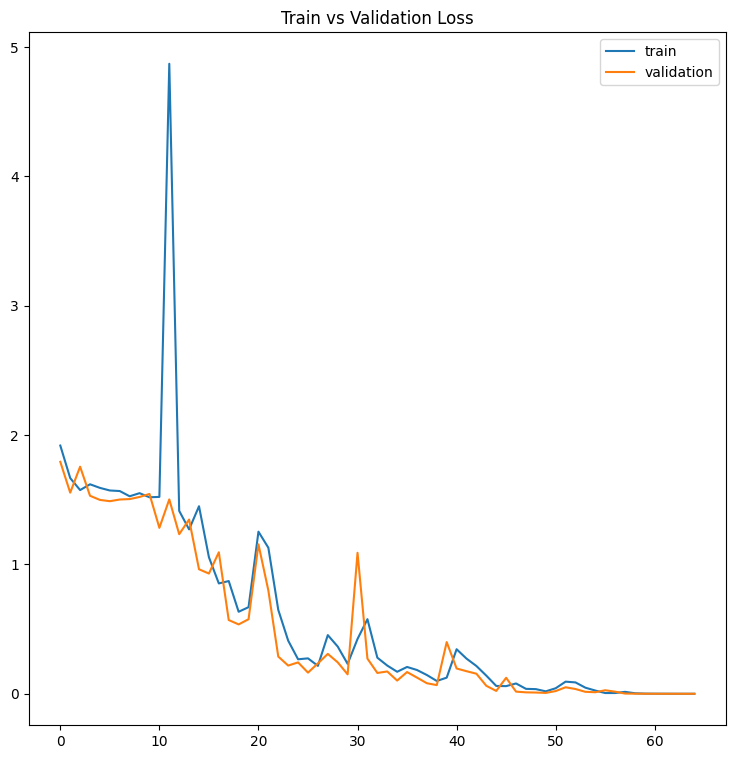

In [45]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

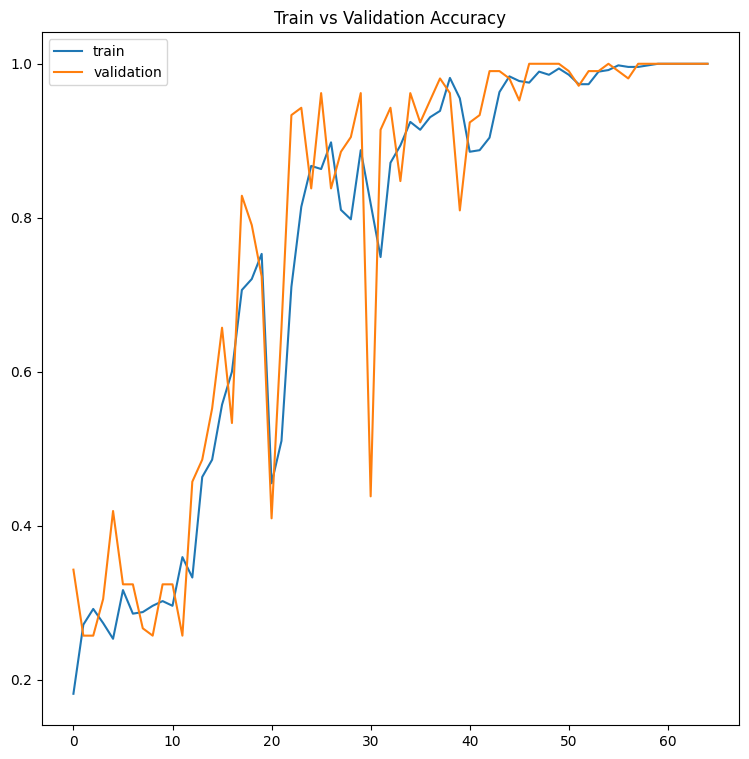

In [46]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='validation')
plt.title('Train vs Validation Categorical Accuracy')
plt.legend()
plt.show()

In [47]:
model.save('lstm_action_recog3.keras')

In [48]:
model.load_weights('lstm_action_recog3.keras')

4/4 [==============================] - 0s 8ms/step


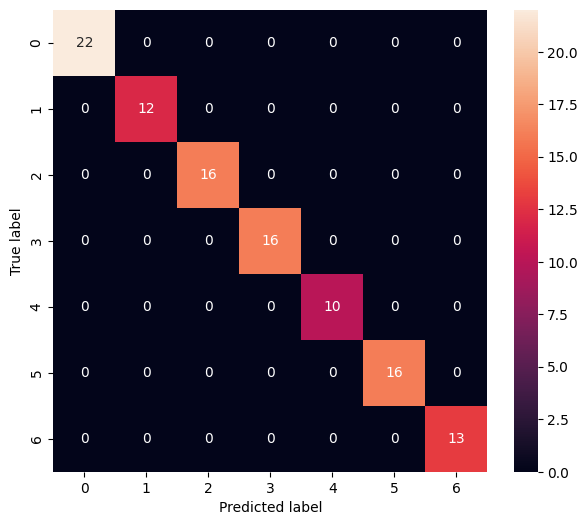

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        13

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}
'''


In [267]:
# from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix

# ypred = model.predict(X_test)
# ytrue = np.argmax(y_test, axis=0)
# ypred = np.argmax(ypred, axis=1)

# accuracy_score(ytrue, ypred)

In [268]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import itertools

# def plot_confusion_matrix(cm,
#                           target_names,
#                           title='Confusion matrix',
#                           cmap=None,
#                           normalize=False):
#     #Citiation
#     #---------
#     #http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

#     accuracy = np.trace(cm) / float(np.sum(cm))
#     misclass = 1 - accuracy

#     if cmap is None:
#         cmap = plt.get_cmap('Blues')

#     plt.figure(figsize=(8, 6))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()

#     if target_names is not None:
#         tick_marks = np.arange(len(target_names))
#         plt.xticks(tick_marks, target_names, rotation=45)
#         plt.yticks(tick_marks, target_names)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


#     thresh = cm.max() / 1.5 if normalize else cm.max() / 2
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         if normalize:
#             plt.text(j, i, "{:0.4f}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")
#         else:
#             plt.text(j, i, "{:,}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")


#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.show()

In [269]:
# cm = confusion_matrix(ytrue, ypred)

# plot_confusion_matrix(cm, signs, cmap='Reds')

# Test in Real Time

In [55]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
current_action = ""
threshold = 0.5
model.load_weights('lstm_action_recog2.keras')

cap = cv.VideoCapture(0)

cap.set(cv.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 720)

# writer= cv2.VideoWriter('livefeed_test.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))

# Set mediapipe model 
mp_holistic = mp.solutions.holistic
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv.flip(frame, 1) 

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        draw_landmarks(image, results)
        
        keypoints = extract_keypoints_v2(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        # if len(sequence) == 30:
        res = model.predict(np.expand_dims(sequence, axis=0))[0]
        print(actions[np.argmax(res)])
        predictions.append(np.argmax(res))
            
            # if np.unique(predictions[-10:])[0]==np.argmax(res): 
        if res[np.argmax(res)] > 0.65:
            # current_action = actions[np.argmax(res)]
            cv.putText(image, actions[np.argmax(res)], (0, 45), cv.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1, cv.LINE_AA)
        # writer.write(image)
        cv.imshow('Live Feed', image)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    # writer.release()
    cv.destroyAllWindows()

NameError: name 'model' is not defined

# Test

In [27]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

In [63]:
colors = [(245,117,16), (117,245,16), (16,117,245), (245,117,16), (117,245,16), (16,117,245), (245,117,16)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv.putText(output_frame, actions[num], (0, 85+num*40), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv.LINE_AA)
        
    return output_frame

In [65]:
cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = False

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)
cap.set(cv.CAP_PROP_FOURCC, cv.VideoWriter.fourcc('m','j','p','g'))

# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

# Prediction vars
model.load_weights('lstm_action_recog2.keras')
pred_sequence = []
current_action = ""
predictions = []
action_list = []
pred_threshold = 0.65

while True:
    display_fps = cvFpsCalc.get()

    # Camera Capture #####################################################
    ret, image = cap.read()
    if not ret:
        break
    image = cv.flip(image, 1)  # ミラー表示
    debug_image = copy.deepcopy(image)

    # Holistics Processing #############################################################
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True

    pose_landmarks = results.pose_landmarks
    if pose_landmarks is not None:
        # 外接矩形の計算
        brect = calc_bounding_rect(debug_image, pose_landmarks)
        # 描画
        debug_image = draw_pose_landmarks_v2(
            debug_image,
            pose_landmarks
        )
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # Hands ###############################################################
    left_hand_landmarks = results.left_hand_landmarks
    right_hand_landmarks = results.right_hand_landmarks
    # 左手
    if left_hand_landmarks is not None:
        brect = calc_bounding_rect(debug_image, left_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)
    # 右手
    if right_hand_landmarks is not None:
        
        brect = calc_bounding_rect(debug_image, right_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # FPS表示
    fps_color = (0, 255, 0)
    cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
               cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)

    # Prediction Logic
    # keypoints is solely used for containing extracted landmarks
    keypoints = extract_keypoints_v2(results)
    # Append keypoint array constantly, until we reach at least 30 frames
    pred_sequence.append(keypoints)
    # Take the last 30 frames, if we have 0-29 30 31 then it'd take 2-31 for prediction
    pred_sequence = pred_sequence[-30:]

    # if len(pred_sequence) == 30:
    #     res = model.predict(np.expand_dims(pred_sequence, axis=0))[0]
    #     print(actions[np.argmax(res)])
    #     predictions.append(np.argmax(res))
    
    #     # Visualization
    #     if np.unique(predictions[-3:])[0]==np.argmax(res):
    #         if res[np.argmax(res)] > pred_threshold:
    #             current_action = actions[np.argmax(res)]
        
    #             # Testing (it's almost 6am spare me from this)
    #             # if len(action_list) > 0:
    #             #     if actions[np.argmax(res)] == 'LSteer' and action_list[-1] == 'RSteer':
    #             #         current_action = 'StaticStraight'
    #             #     if actions[np.argmax(res)] == 'RSteer' and action_list[-1] == 'LSteer':
    #             #         current_action = 'StaticStraight'
    #             # else:
    #             #     action_list.append(actions[np.argmax(res)])
    
    #     if len(action_list) > 5:
    #         action_list = action_list[-5:]

    if len(pred_sequence) == 30:
        res = model.predict(np.expand_dims(pred_sequence, axis=0))[0]
        print(actions[np.argmax(res)])
        predictions.append(np.argmax(res))
    
        # Visualization
        if np.unique(predictions[-10:])[0]==np.argmax(res):
            if res[np.argmax(res)] > 0.7:
                current_action = actions[np.argmax(res)]
        
                # Testing (it's almost 6am spare me from this)
                # if len(action_list) > 0:
                #     if actions[np.argmax(res)] == 'LSteer' and action_list[-1] == 'RSteer':
                #         current_action = 'StaticStraight'
                #     if actions[np.argmax(res)] == 'RSteer' and action_list[-1] == 'LSteer':
                #         current_action = 'StaticStraight'
                # else:
                #     action_list.append(actions[np.argmax(res)])

        debug_image = prob_viz(res, actions, debug_image, colors)
    
        # if len(action_list) > 5:
        #     action_list = action_list[-5:]
    
                
    cv.putText(debug_image, "Gesture:" + current_action, (10, 70),
           cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)
    
    # キー処理(ESC：終了) #################################################
    key = cv.waitKey(1)
    if key == 27:  # ESC
        break

    # 画面反映 #############################################################
    cv.imshow('MediaPipe Holistic Demo', debug_image)

cap.release()
cv.destroyAllWindows()

1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 12ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 12ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==============================] - 0s 10ms/step
Idle
1/1 [==============================] - 0s 11ms/step
Idle
1/1 [==========================

In [62]:
    cap.release()
    cv.destroyAllWindows()